In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/Github/ssm_julia/")
# Pkg.activate("/home/ryansenne/PycharmProjects/ssm_julia/")

  Activating project at `\Users\ryansenne\Documents\Github\ssm_julia`


In [2]:
include("/Users/ryansenne/Documents/Github/ssm_julia//src/SSM.jl")
# include("/home/ryansenne/PycharmProjects/ssm_julia/src/SSM.jl")
using Random
using .SSM
using Distributions
using Plots
using LinearAlgebra
using ForwardDiff
using StatsFuns
using Optim

In [2]:
# generate synthetic data
Random.seed!(123)

# set parameters
n = 1000
β = [0.1, 0.9]

# generate data
X = hcat(ones(n), randn(n, 1))

p = logistic.(X * β)
y = rand.(Bernoulli.(p));

logreg = SSM.BernoulliRegression()
SSM.fit!(logreg, reshape(X[:, 2], length(y), 1), y)

2-element Vector{Float64}:
 -0.16475074895339847
  0.9130020117197616

In [6]:
model = SSM.SwitchingBernoulliRegression(;K=2, λ=0.1)
SSM.fit!(model, reshape(X[:, 2], length(y), 1), y, 1)

Log-Likelihood at iter 1: -661.47029776173


2-element Vector{Float64}:
  -Inf
 -661.47029776173

In [5]:
# synthetic poisson regression data
Random.seed!(123)

# set parameters
n = 100
β = [0.1, 0.9]
# generate data

X = hcat(ones(n), randn(n, 1))
λ = exp.(X * β)

y = rand.(Poisson.(λ))

poisreg = SSM.PoissonRegression()
SSM.fit!(poisreg, reshape(X[:, 2], length(y), 1), y)

2-element Vector{Float64}:
 0.17487914508365066
 0.947349969129698

In [6]:
model = SSM.SwitchingPoissonRegression(;K=2, λ=0.1)
fit!(model, reshape(X[:, 2], length(y), 1), y)

Log-Likelihood at iter 1: -156.45428974993172
Log-Likelihood at iter 2: -135.25621720804358
Log-Likelihood at iter 3: -134.16285096688912
Log-Likelihood at iter 4: -133.83642369645605
Log-Likelihood at iter 5: -133.7079105961072
Log-Likelihood at iter 6: -133.64984042864145
Log-Likelihood at iter 7: -133.62099977477772
Log-Likelihood at iter 8: -133.6058209832856
Log-Likelihood at iter 9: -133.5975567520573
Log-Likelihood at iter 10: -133.59296693195853
Log-Likelihood at iter 11: -133.59038555167996
Log-Likelihood at iter 12: -133.58891948685175
Log-Likelihood at iter 13: -133.58807819216423
Log-Likelihood at iter 14: -133.58758851551048
Log-Likelihood at iter 15: -133.58729717669178
Log-Likelihood at iter 16: -133.587117786321
Log-Likelihood at iter 17: -133.5870015358344
Log-Likelihood at iter 18: -133.58692081297323
Log-Likelihood at iter 19: -133.58685998772486
Log-Likelihood at iter 20: -133.58681021236723
Log-Likelihood at iter 21: -133.58676648071955
Log-Likelihood at iter 22: -

101-element Vector{Float64}:
  -Inf
 -156.45428974993172
 -135.25621720804358
 -134.16285096688912
 -133.83642369645605
 -133.7079105961072
 -133.64984042864145
 -133.62099977477772
 -133.6058209832856
 -133.5975567520573
    ⋮
 -133.58367065036043
 -133.58362956826656
 -133.5835888251289
 -133.5835484279308
 -133.58350838327405
 -133.58346869737287
 -133.58342937616737
 -133.58339042503604
 -133.58335184922993

In [4]:
# Parameters
n = 1000
β₁ = [0.1, 0.9]
β₂ = [0.9, 0.1]
σ²₁ = 0.1
σ²₂ = 0.1
A = [0.9 0.1; 0.1 0.9]

# Data generation
X = hcat(ones(n), randn(n, 1))
y = zeros(n)
state = Vector{Int}(undef, n)

for i in 1:n
    if i == 1
        # choose a state at random
        state[i] = rand(1:2)
    else
        # Transition based on previous state
        state[i] = rand(Categorical(A[state[i-1], :]))
    end

    if state[i] == 1
        y[i] = X[i, :]' * β₁ + sqrt(σ²₁) * randn()
    else
        y[i] = X[i, :]' * β₂ + sqrt(σ²₂) * randn()
    end
end

# Fit linear regression model
linreg = SSM.SwitchingGaussianRegression(; K=2, λ=0.1)
SSM.fit!(linreg, reshape(X[:, 2], length(y), 1), y, 10000, 1e-6)

println("Fitted coefficients: ", linreg.B[1].regression.β)


Log-Likelihood at iter 1: -2244.1947396433807
Log-Likelihood at iter 2: -937.5261652755305
Log-Likelihood at iter 3: -884.6763569120992
Log-Likelihood at iter 4: -826.9635144417072
Log-Likelihood at iter 5: -763.6663121626486
Log-Likelihood at iter 6: -691.0600089593686
Log-Likelihood at iter 7: -610.0696308298095
Log-Likelihood at iter 8: -538.6388320229214
Log-Likelihood at iter 9: -501.05907239480405
Log-Likelihood at iter 10: -490.50824733480823
Log-Likelihood at iter 11: -488.88410363213836
Log-Likelihood at iter 12: -488.7032759932098
Log-Likelihood at iter 13: -488.6841497303064
Log-Likelihood at iter 14: -488.6821148256833
Log-Likelihood at iter 15: -488.6819200994061
Log-Likelihood at iter 16: -488.6819120487494
Log-Likelihood at iter 17: -488.68191636353725
Log-Likelihood at iter 18: -488.6819187215012
Log-Likelihood at iter 19: -488.6819196441826
Fitted coefficients: [0.909748489134757, 0.09867808009520528]


In [6]:
γ, ξ, α, β = SSM.E_step(linreg, reshape(X[:, 2], length(y), 1), y)

([-75.87673888014962 0.0; -4.358147113852738 -0.012884739382513999; … ; -15.723065321341892 -1.4844295037619304e-7; -9.33237047628262 -8.851608964732804e-5], [-76.33274147778928 -4.358147113852738; -7.973119689790451 -8.494646684882468; … ; -16.412831361035387 -16.41960511367762; -20.17324319908289 -9.33239005900424;;; -76.88134781712512 -0.012884739382513999; -4.385433692850711 -0.013091974136557383; … ; -4.894610105425329 -0.007515144261390105; -15.73481051669711 -8.866281228847583e-5], [-74.39685374344596 0.22427840316698913; -2.8158847022861235 -0.6908739147016703; … ; -502.00541278963664 -488.5180218668815; -498.01429045292537 -488.6820084927324], [-490.1618051133434 -488.90619837980677; -490.22418238820643 -488.0039308013206; … ; -2.3995725083480184 -0.16389825820418885; 0.0 0.0])

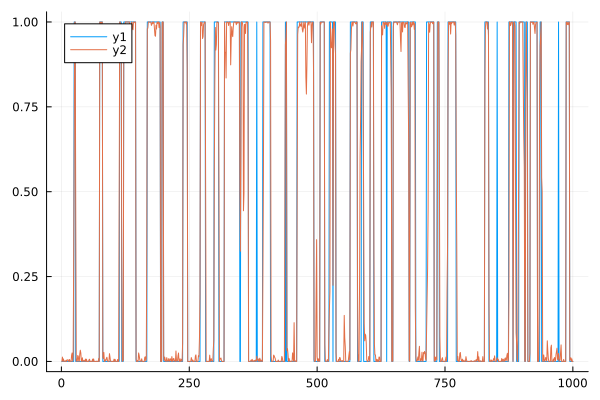

In [7]:
plot(state.-1)
plot!(exp.(γ[:, 1]))